## Installing uv

To start, you'll want to have uv installed:

https://docs.astral.sh/uv/getting-started/installation/


**Next, run this in the terminal, from the parent directory:**

    uv sync


Now you will have the kernel used to run this notebook

---

## Running the Required Servers

You need to run **three servers**, each in its own terminal:

- `central_server.py`
- `AS_server_SimAu.py`
- `Ceos_server_twin.py`

### 1. Activate the Virtual Environment

`uv` should have created a `.venv` directory for you.

**On macOS / Linux:**

    source .venv/bin/activate

**On Windows (likely):**

    source .venv/Scripts/activate

You should now see the environment activated.

---

### 2. Start the Servers

**Terminal 1 — Central Server**

    source .venv/bin/activate
    python -m asyncroscopy.servers.protocols.central_server

**Terminal 2 — Atom Resolution Simulation Server**

    source .venv/bin/activate
    python -m asyncroscopy.servers.AS_server_SimAu

**Terminal 3 — CEOS Twin Server**

    source .venv/bin/activate
    python -m asyncroscopy.servers.Ceos_server_twin

---

You're now ready to run this notebook! 🚀

In [1]:
import sys
import ast
import numpy as np
sys.path.insert(0, '../')
from asyncroscopy.clients.notebook_client import NotebookClient
import matplotlib.pyplot as plt

import pyTEMlib
from pyTEMlib import probe_tools as pt

### Connections:

In [2]:
# Connect the Client to the central (async) server
tem = NotebookClient.connect(host='localhost',port=9000)

# Tell the central server address of all connected instruments
routing_table= {"AS": ("localhost", 9001),
                "Gatan": ("localhost", 9002),
                "Ceos": ("localhost", 9003)}
tem.send_command('Central',"set_routing_table", routing_table)

# ConnectionResetError: [Errno 54] Connection reset by peer 
# in terminal, type:
# lsof -i :9000

Connecting to central server localhost:9000...
Connected to central server.


'[Central] Routing table updated'

In [3]:
# connect to the AutoScript computer and initialize microscope
tem.send_command('AS',command='connect_AS',args={'host':'localhost','port':9095})

'Connected to Digital Twin microscope.'

In [4]:
tem.send_command(destination = 'Ceos', command = 'getInfo', args = {})

'CEOS Digital Twin Server'

### Help commands:

In [5]:
# Now that we're routed to all instruments,
# let's take an inventory of commands available on each instrument
cmds = tem.send_command('AS', 'discover_commands')
print(cmds)

["connect_AS", "connectionLost", "connectionMade", "dataReceived", "disconnect", "discover_commands", "get_help", "get_scanned_image", "get_stage", "get_status", "lengthLimitExceeded", "logPrefix", "makeConnection", "move_stage", "pauseProducing", "resumeProducing", "sendString", "set_current", "stopProducing", "stringReceived"]


In [6]:
# These two are working, but should be much better.
tem.send_command('AS', command='get_help', args={'command_name':'connect_AS'})

'{"name": "connect_AS", "signature": "(args: dict)", "summary": "Connect to the microscope via AutoScript", "doc": "Connect to the microscope via AutoScript"}'

### Setting the aberrations from known values:

In [7]:
aberrations = pt.get_target_aberrations("Spectra300", 60000)
tem.send_command(destination = 'Ceos', command = 'uploadAberrations', args = aberrations)
pt.print_aberrations(aberrations)

In [8]:
# at any time, we can view the current aberrations
# this should be implemented in the real ceos server as well
ab = tem.send_command(destination = 'Ceos', command = 'getAberrations', args={})
ab = ast.literal_eval(ab)
pt.print_aberrations(ab)

### Get an image:

simulated with pystemsim inside the AS_server_SimAtomRes (working with the Ceos server)

In [11]:
# first set the beam current
set_current = tem.send_command(destination = 'AS', command = 'set_current', args = {'beam_current': 100})

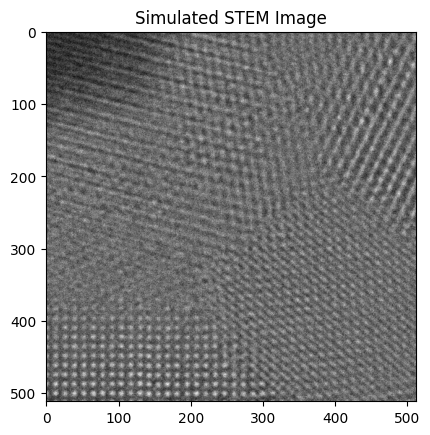

In [22]:
image_args = {'scanning_detector':'HAADF',
                'size':512,
                'dwell_time':10e-6,
                'fov':80,
                'blur_noise':0.5} # nm

img = tem.send_command('AS','get_scanned_image', image_args)

plt.imshow(img, cmap="gray")
plt.title("Simulated STEM Image")
plt.show()


### moving the stage yields a different sample

In [26]:
tem.send_command('AS','move_stage', {'move_type':'relative', 'x':100})

'stage move finished'

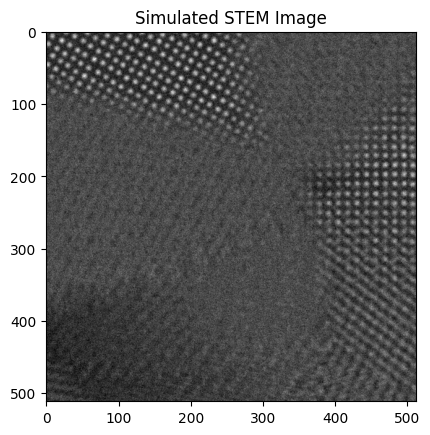

In [27]:
img = tem.send_command('AS','get_scanned_image', image_args)

plt.imshow(img, cmap="gray")
plt.title("Simulated STEM Image")
plt.show()

### higher noise image

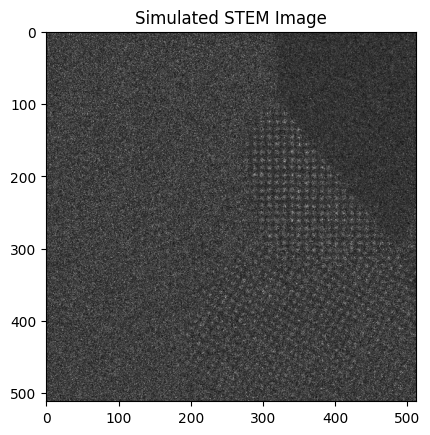

In [34]:
image_args = {'scanning_detector':'HAADF',
                'size':512,
                'dwell_time':0.1e-6,
                'fov':100,
                'blur_noise':0.5} # nm

img = tem.send_command('AS','get_scanned_image', image_args)

plt.imshow(img, cmap="gray")
plt.title("Simulated STEM Image")
plt.show()


### zoom in and increase dwell time

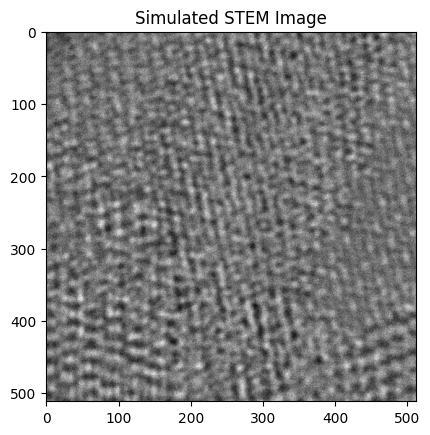

In [36]:
image_args = {'scanning_detector':'HAADF',
                'size':512,
                'dwell_time':20e-6,
                'fov':50,
                'blur_noise':0.5} # nm

img = tem.send_command('AS','get_scanned_image', image_args)

plt.imshow(img, cmap="gray")
plt.title("Simulated STEM Image")
plt.show()


### Look how contrast changes with focus:

In [37]:
def contrast_rms(image):
    img_mean = np.mean(image)
    img_contrast = (np.max(image) - np.min(image)) / img_mean
    return img_contrast

Text(0.5, 1.0, 'contrast vs focus')

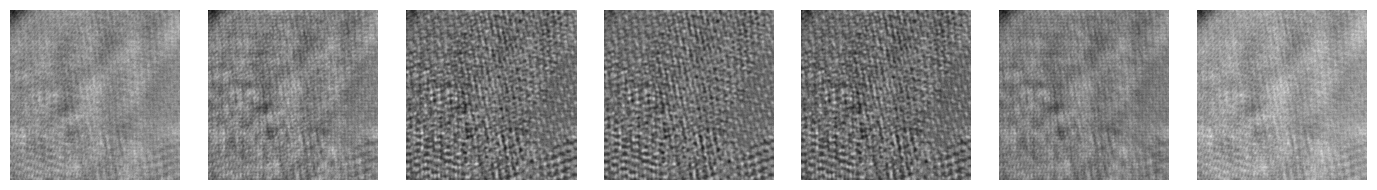

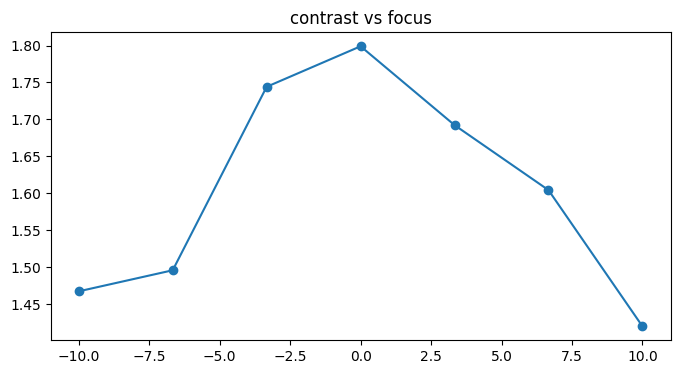

In [38]:
ab_vals = np.linspace(-10,10,7)
fig, ax = plt.subplots(1,7, figsize=(14,2))
contrast = []
for i in range(7):
    tem.send_command(destination = 'Ceos', command = 'correctAberration', args = {"name": 'C10', "value": ab_vals[i]})
    img = tem.send_command('AS','get_scanned_image', image_args)
    ax[i].imshow(img, cmap="gray")
    ax[i].axis('off')
    contrast.append(contrast_rms(img))
fig.tight_layout()

fig, ax = plt.subplots(1,1, figsize=(8,4))
ax.plot(ab_vals, contrast, '-o')
ax.set_title('contrast vs focus')
